In [1]:
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVR


In [2]:
### Set-up - Define file location
filename = 'N-CMAPSS_DS02-006.h5'

In [3]:
# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 

In [4]:

#columns described 

df_A_columns = ['unit',	'cycle', 'Fc','hs']
df_W_columns = ['alt', 'Mach', 'TRA', 'T2']
df_T_columns = ['fan_eff_mod','fan_flow_mod','LPC_eff_mod', 'LPC_flow_mod','HPC_eff_mod','HPC_flow_mod','HPT_eff_mod','HPT_flow_mod','LPT_eff_mod', 'LPT_flow_mod']
df_X_s_columns = ['T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc',
                  'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40', 'P2']
df_X_v_columns = ['T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc',
                  'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40', 'P2']

# Create DataFrames with the specified columns
df_A_dev = DataFrame(data=A_dev, columns=df_A_columns)
df_W_dev = DataFrame(data=W_dev, columns=df_W_columns)
df_T_dev = DataFrame(data=T_dev, columns=df_T_columns)
df_X_s_dev = DataFrame(data=X_s_dev, columns=df_X_s_columns)
df_X_v_dev = DataFrame(data=X_v_dev, columns=df_X_v_columns)

# Separate features (X) and target variable (y)
df_A_test = DataFrame(data=A_test, columns=df_A_columns)
df_W_test = DataFrame(data=W_test, columns=df_W_columns)
df_T_test = DataFrame(data=T_test, columns=df_T_columns)
df_X_s_test = DataFrame(data=X_s_test, columns=df_X_s_columns)
df_X_v_test = DataFrame(data=X_v_test, columns=df_X_v_columns)


#Inputs Data development / training 
df_W_dev['unit'] = df_A_dev['unit'].values
df_W_dev_u = df_W_dev.loc[(df_A_dev.unit == 2) & (df_A_dev.cycle == 42)]
df_W_dev_u.reset_index(inplace=True, drop=True)

df_T_dev['unit'] = df_A_dev['unit'].values
df_T_dev_u = df_T_dev.loc[(df_A_dev.unit == 2) & (df_A_dev.cycle == 42)]
df_T_dev_u.reset_index(inplace=True, drop=True)

#Outputs Data development / training 

df_X_s_dev['unit'] = df_A_dev['unit'].values
df_X_s_dev_u = df_X_s_dev.loc[(df_A_dev.unit == 2) & (df_A_dev.cycle == 42)]
df_X_s_dev_u.reset_index(inplace=True, drop=True)

df_X_v_dev['unit'] = df_A_dev['unit'].values
df_X_v_dev_u = df_X_v_dev.loc[(df_A_dev.unit == 2) & (df_A_dev.cycle == 42)]
df_X_v_dev_u.reset_index(inplace=True, drop=True)



In [22]:
print('Engine units in df_test: ', np.unique(df_A_test['unit']))

Engine units in df_test:  [11. 14. 15.]


In [5]:
#Inputs Data test
df_W_test['unit'] = df_A_test['unit'].values
df_W_test_u = df_W_test.loc[(df_A_test.unit == 11) & (df_A_test.cycle == 42)]
df_W_test_u.reset_index(inplace=True, drop=True)

df_T_test['unit'] = df_A_test['unit'].values
df_T_test_u = df_T_test.loc[(df_A_test.unit == 11) & (df_A_test.cycle == 42)]
df_T_test_u.reset_index(inplace=True, drop=True)

df_X_s_test['unit'] = df_A_test['unit'].values
df_X_s_test_u = df_X_s_test.loc[(df_A_test.unit == 11) & (df_A_test.cycle == 42)]
df_X_s_test_u.reset_index(inplace=True, drop=True)

In [6]:
#Inputs Data test with a fight class of type 2

# Inputs 
df_W_test_u_1 = df_W_test.loc[(df_A_test.unit == 15) & (df_A_test.cycle == 42)]
df_W_test_u_1.reset_index(inplace=True, drop=True)

df_T_test_u_1 = df_T_test.loc[(df_A_test.unit == 15) & (df_A_test.cycle == 42)]
df_T_test_u_1.reset_index(inplace=True, drop=True)

#Outputs

df_X_s_test_u_1= df_X_s_test.loc[(df_A_test.unit == 15) & (df_A_test.cycle == 42)]
df_X_s_test_u_1.reset_index(inplace=True, drop=True)


df_w_test_u_3 = df_W_test_u_1 [['alt', 'Mach', 'TRA', 'T2']]
df_T_test_u_3 = df_T_test_u_1 [['fan_eff_mod','fan_flow_mod','LPC_eff_mod', 'LPC_flow_mod','HPC_eff_mod','HPC_flow_mod','HPT_eff_mod','HPT_flow_mod','LPT_eff_mod', 'LPT_flow_mod']]
X_test_unit15= pd.concat([df_w_test_u_3, df_T_test_u_3], axis=1)

In [24]:
print(df_W_test_u)

           alt      Mach        TRA          T2  unit
0      10005.0  0.448497  76.903748  502.420918  11.0
1      10013.0  0.447741  76.903748  502.326114  11.0
2      10017.0  0.448938  77.079529  502.416067  11.0
3      10024.0  0.449883  77.079529  502.469893  11.0
4      10031.0  0.449379  77.079529  502.401271  11.0
...        ...       ...        ...         ...   ...
11759  10037.0  0.454230  25.839661  502.803044  11.0
11760  10029.0  0.454293  25.839661  502.836867  11.0
11761  10021.0  0.454419  25.839661  502.878338  11.0
11762  10012.0  0.454293  25.839661  502.901329  11.0
11763  10005.0  0.454356  25.839661  502.931592  11.0

[11764 rows x 5 columns]


In [7]:
# Concatenate feature DataFrames (df_W_dev_u, df_T_dev_u, etc.) horizontally
df_w_dev_u_2 = df_W_dev_u [['alt', 'Mach', 'TRA', 'T2']]
df_T_dev_u_2 = df_T_dev_u [['fan_eff_mod','fan_flow_mod','LPC_eff_mod', 'LPC_flow_mod','HPC_eff_mod','HPC_flow_mod','HPT_eff_mod','HPT_flow_mod','LPT_eff_mod', 'LPT_flow_mod']]
X_train = pd.concat([df_w_dev_u_2, df_T_dev_u_2], axis=1)
df_X_s_dev_u_2 = df_X_s_dev_u[['T48']]
y_train = df_X_s_dev_u_2['T48'].values.ravel()


df_w_test_u_2 = df_W_test_u [['alt', 'Mach', 'TRA', 'T2']]
df_T_test_u_2 = df_T_test_u [['fan_eff_mod','fan_flow_mod','LPC_eff_mod', 'LPC_flow_mod','HPC_eff_mod','HPC_flow_mod','HPT_eff_mod','HPT_flow_mod','LPT_eff_mod', 'LPT_flow_mod']]
X_test= pd.concat([df_w_test_u_2, df_T_test_u_2], axis=1)
y_test = df_X_s_test['T48']

print(X_test)
# y_test= pd.concat([df_X_s_test, df_X_v_test], axis=1)

           alt      Mach        TRA          T2  fan_eff_mod  fan_flow_mod  \
0      10005.0  0.448497  76.903748  502.420918          0.0           0.0   
1      10013.0  0.447741  76.903748  502.326114          0.0           0.0   
2      10017.0  0.448938  77.079529  502.416067          0.0           0.0   
3      10024.0  0.449883  77.079529  502.469893          0.0           0.0   
4      10031.0  0.449379  77.079529  502.401271          0.0           0.0   
...        ...       ...        ...         ...          ...           ...   
11759  10037.0  0.454230  25.839661  502.803044          0.0           0.0   
11760  10029.0  0.454293  25.839661  502.836867          0.0           0.0   
11761  10021.0  0.454419  25.839661  502.878338          0.0           0.0   
11762  10012.0  0.454293  25.839661  502.901329          0.0           0.0   
11763  10005.0  0.454356  25.839661  502.931592          0.0           0.0   

       LPC_eff_mod  LPC_flow_mod  HPC_eff_mod  HPC_flow_mod  HP

In [12]:
print(y_train)

[604.22193167 604.22356408 604.25632973 ... 582.95598249 583.23971759
 583.48418964]


In [26]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to your training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform your test data using the same scaler
X_test_scaled = scaler.transform(X_test)



In [42]:
X_test_scaled_unit15 = scaler.transform(X_test_unit15)


In [29]:
df_X_s_dev_u_2 = df_X_s_dev_u [['T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40', 'P2']]
y_train_multiple = df_X_s_dev_u_2

df_X_s_test_u_2 = df_X_s_test_u [['T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40', 'P2']]
y_test_multiple = df_X_s_test_u_2
print (y_test_multiple)

              T48          T50          P50           Wf         Nf  \
0      600.492783  1437.383601  1828.542970  1236.291685  15.807572   
1      600.400392  1437.239310  1828.191778  1236.036220  15.796784   
2      600.557302  1437.975445  1830.619466  1237.651580  15.809000   
3      600.715860  1438.132758  1829.735466  1236.726147  15.817692   
4      600.644156  1437.950322  1829.488817  1236.557834  15.808835   
...           ...          ...          ...          ...        ...   
11759  550.195759  1213.015053  1405.333616  1056.580156  13.310152   
11760  550.115583  1213.324083  1408.086373  1058.839163  13.310235   
11761  550.182370  1213.404494  1407.374280  1058.187569  13.316539   
11762  550.204547  1213.451258  1407.608324  1058.408647  13.320084   
11763  550.237458  1213.527769  1407.671998  1058.444336  13.324055   

              Nc        T24        T30         P15         P21        P24  \
0      11.577097  16.048296  20.151271  330.551199  335.771071  12.624

In [44]:
df_X_s_test_u_3 = df_X_s_test_u_1 [['T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40', 'P2']]
y_test_multiple_unit15 = df_X_s_test_u_3

In [18]:
from sklearn.multioutput import MultiOutputRegressor


svr = SVR(kernel='rbf', C=5, gamma=3, degree=1, epsilon= 0.2)
multioutput_regressor = MultiOutputRegressor(svr)

# Fit the model
multioutput_regressor.fit(X_train_scaled, y_train_multiple)

MultiOutputRegressor(estimator=SVR(C=5, degree=1, epsilon=0.2, gamma=3))

In [27]:
# Predict on the test set Unit 11
y_pred = multioutput_regressor.predict(X_test_scaled)


In [43]:
# Predict on the test set Unit 15
y_pred_unit15 = multioutput_regressor.predict(X_test_scaled_unit15)

In [32]:
print(y_pred.shape)

(11764, 14)


In [35]:
multioutput_regressor.score(X_train_scaled, y_train_multiple)

0.9965376982170309

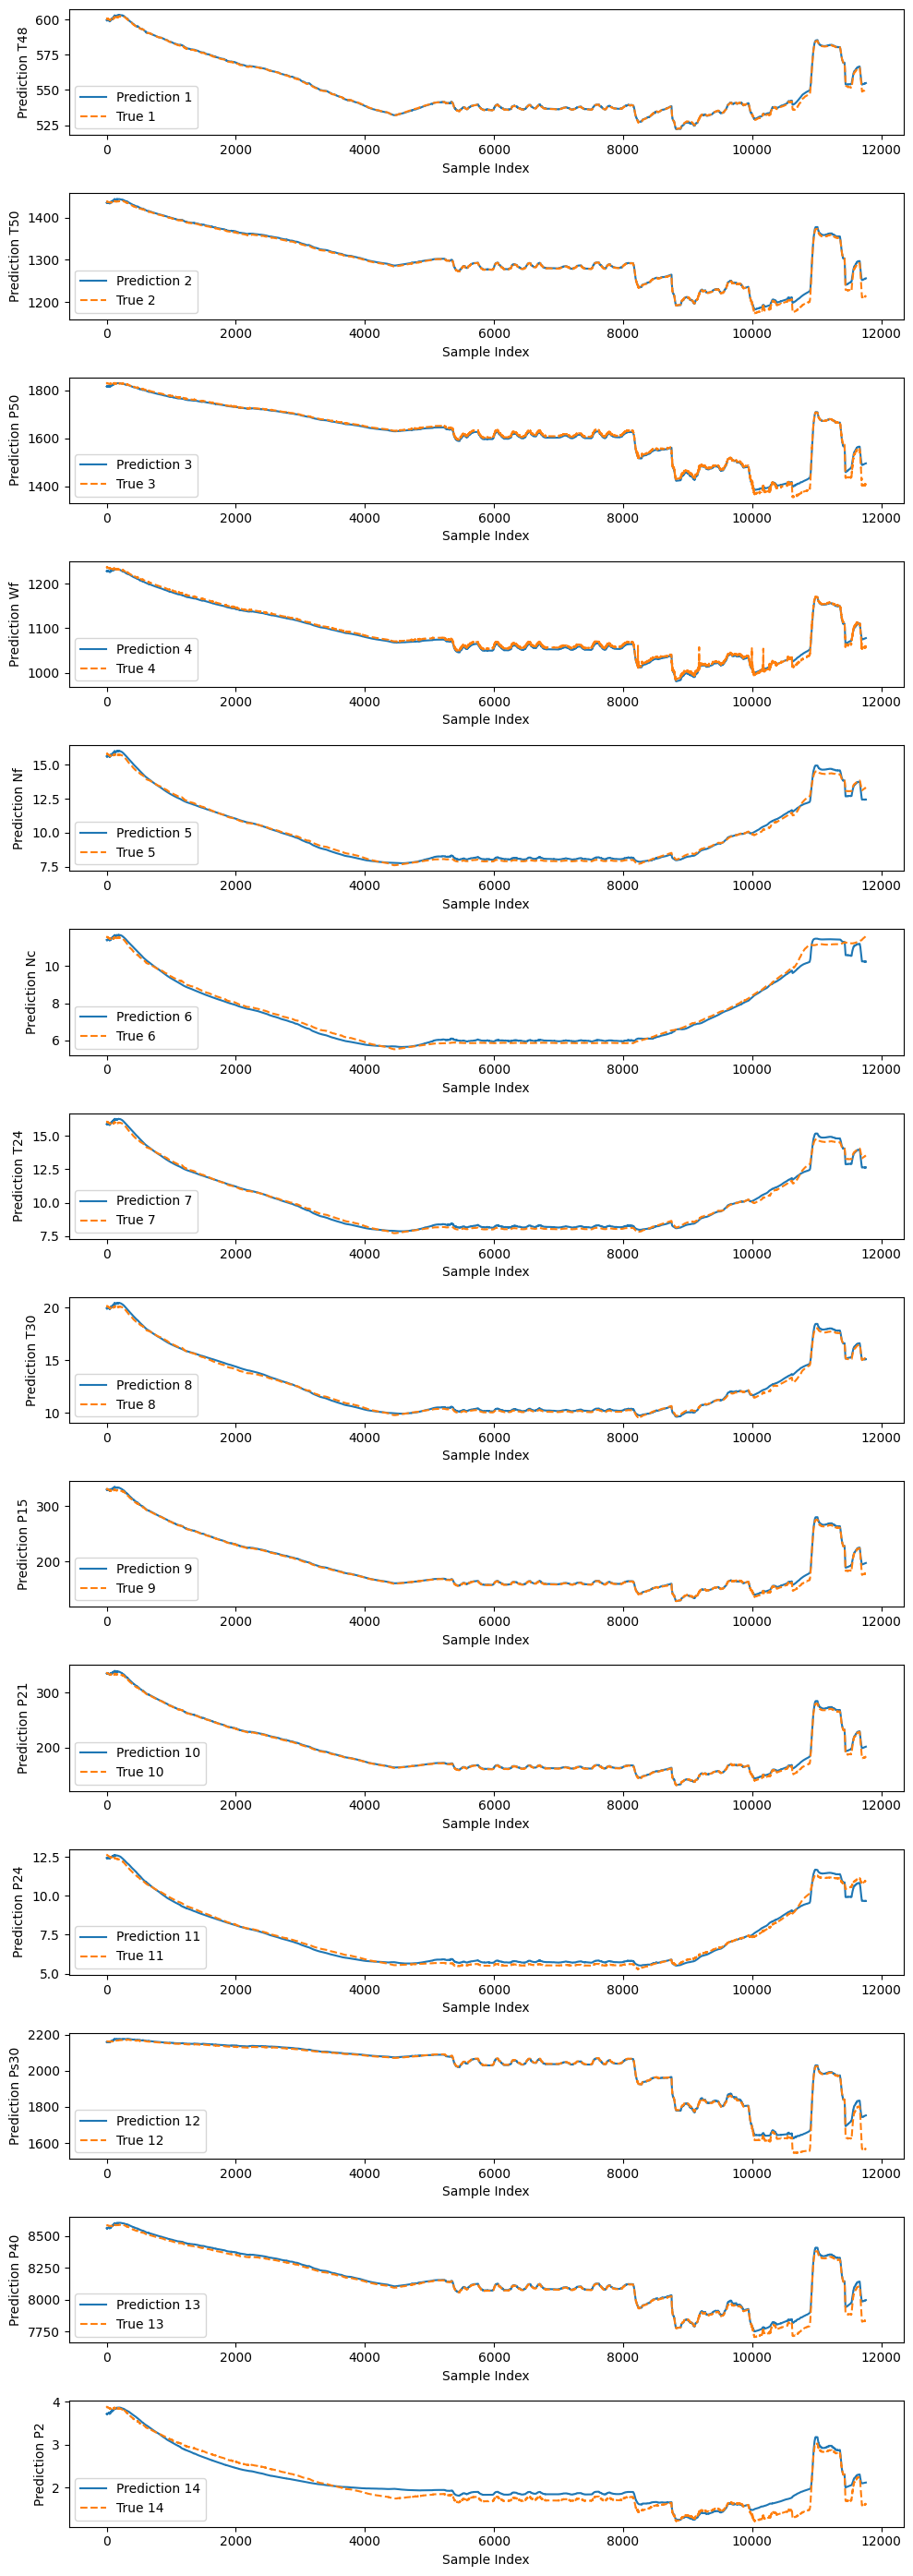

In [38]:
column_labels = ['T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40', 'P2']

# Get the number of columns (predictions)
num_columns = y_pred.shape[1]

# Create subplots
fig, axes = plt.subplots(nrows=num_columns, figsize=(10, 2*num_columns))

# Iterate over columns and plot
for i in range(num_columns):
    axes[i].plot(y_pred[:, i], label=f'Prediction {i+1}')
    axes[i].plot(y_test_multiple.iloc[:, i], label=f'True {i+1}', linestyle='dashed')  # Assuming y_test is a DataFrame
    axes[i].set_xlabel('Sample Index')
    axes[i].set_ylabel(f'Prediction {column_labels[i]}')  # Use the column label here
    axes[i].legend()

plt.tight_layout()
plt.show()


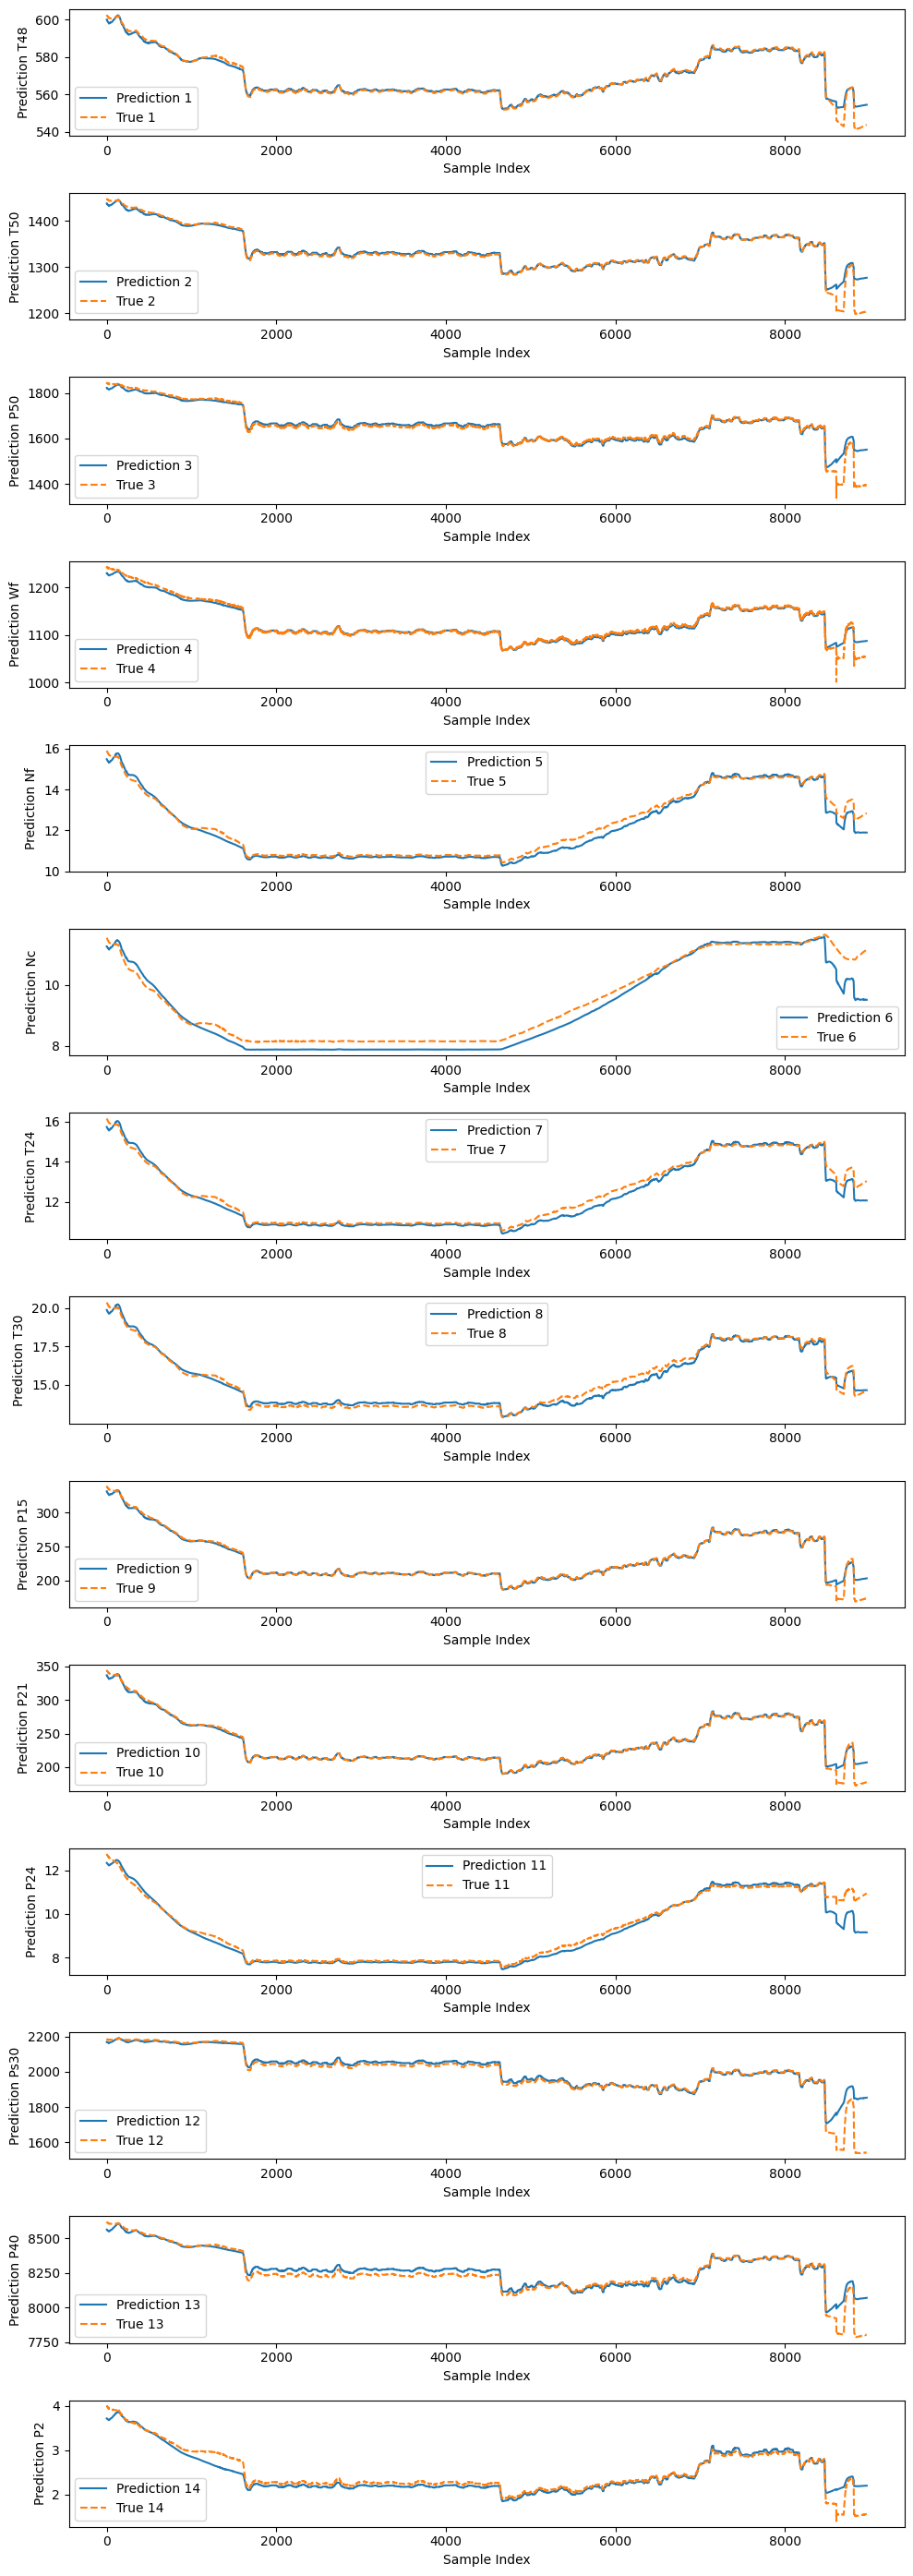

In [45]:
column_labels = ['T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40', 'P2']

# Get the number of columns (predictions)
num_columns = y_pred_unit15.shape[1]

# Create subplots
fig, axes = plt.subplots(nrows=num_columns, figsize=(10, 2*num_columns))

# Iterate over columns and plot
for i in range(num_columns):
    axes[i].plot(y_pred_unit15[:, i], label=f'Prediction {i+1}')

    
    axes[i].plot(y_test_multiple_unit15.iloc[:, i], label=f'True {i+1}', linestyle='dashed')  # Assuming y_test is a DataFrame
    axes[i].set_xlabel('Sample Index')
    axes[i].set_ylabel(f'Prediction {column_labels[i]}')  # Use the column label here
    axes[i].legend()

plt.tight_layout()
plt.show()


In [9]:
# Create an SVR regressor with an appropriate kernel (e.g., 'rbf')
regressor = SVR(kernel='rbf', C=5, gamma=3, degree=1, epsilon= 0.2)

# Train the regressor on the training data
regressor.fit(X_train_scaled, y_train)

SVR(C=5, degree=1, epsilon=0.2, gamma=3)

In [10]:
regressor.score(X_train_scaled, y_train)

0.9999593572305892

In [11]:
y_predict = regressor.predict(X_test)

c:\Users\Diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


In [83]:
param_space = {
    'C': Real(0.1, 10.0),
    'kernel': Categorical(['linear', 'rbf', 'poly']),
    'gamma': Real(0.1, 10.0),
    'degree': Integer(2, 4),
    'epsilon': Real(0.01, 0.2)
}


In [41]:
#Hyperparamter tuning using Gridsearch
svm = SVR()
# param_grid = {'C':[0.01,0.05,0.1,1,10, 100, 1000],'kernel':['linear','rbf'], 'gamma':['scale','auto'] }
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}
grid = GridSearchCV(svm,param_grid)

In [42]:
#Fitting the model
grid.fit(X_train_scaled,y_train)
 

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']})

In [46]:
grid.score(X_train_scaled, y_train)

0.9999824726385316

In [47]:
y_predict = grid.predict(X_test_scaled)

In [58]:
print(len(X_test_scaled))

1253743


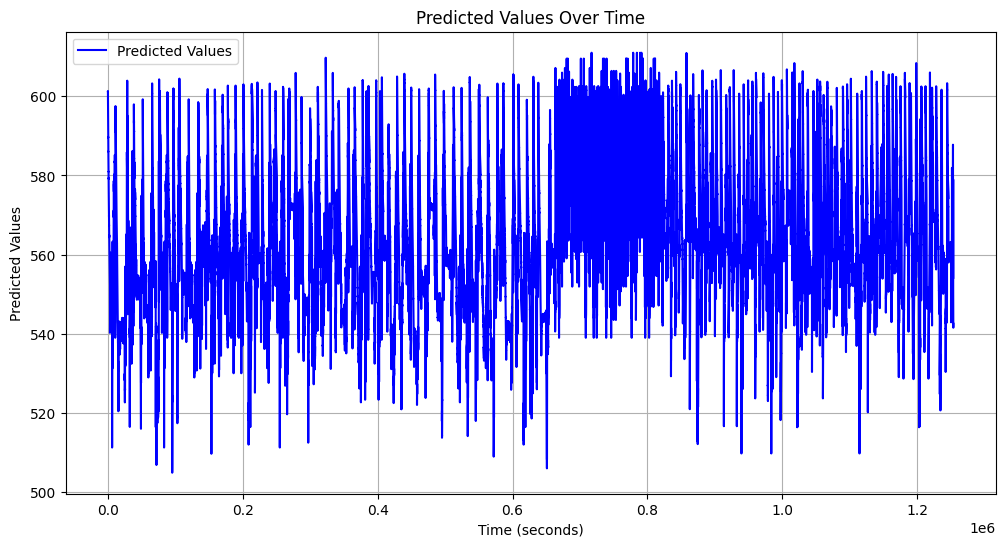

In [48]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
time_seconds = np.arange(len(y_predict))  # This creates an index from 0 to len(y_predict) - 1

# Plotting the predicted values against time
plt.plot(time_seconds, y_predict, label='Predicted Values', color='blue')

# Add labels and a legend
plt.xlabel('Time (seconds)')
plt.ylabel('Predicted Values')
plt.legend()

# Show the plot
plt.title('Predicted Values Over Time')
plt.grid(True)
plt.show()

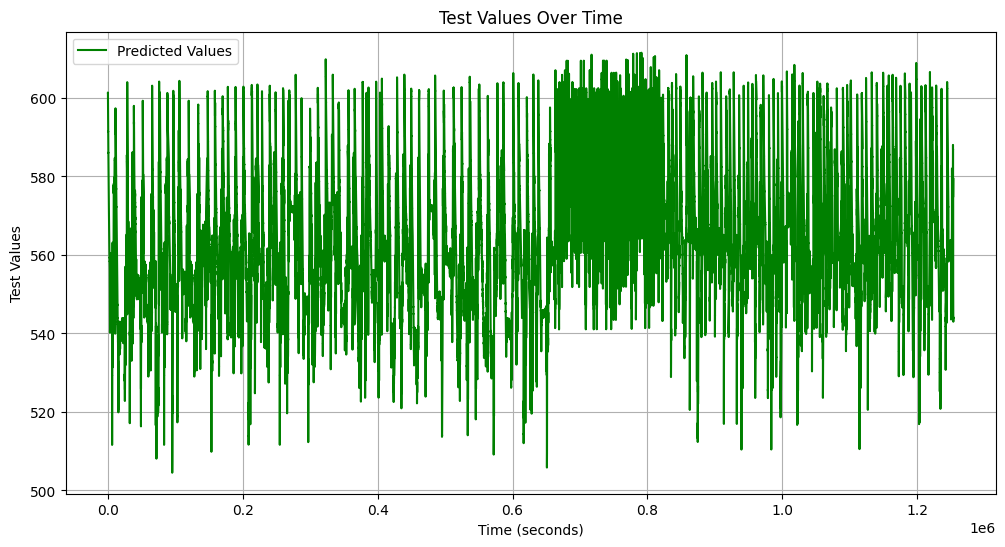

In [66]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
time_seconds = np.arange(len(y_test))  # This creates an index from 0 to len(y_predict) - 1
time_seconds = np.arange(len(y_predict))  # This creates an index from 0 to len(y_predict) - 1

# Plotting the predicted values against time
plt.plot(time_seconds, y_predict, label='Predicted Values', color='blue')

# Plotting the predicted values against time
plt.plot(time_seconds, y_test, label='Predicted Values', color='Green')

# Add labels and a legend
plt.xlabel('Time (seconds)')
plt.ylabel('Test Values')
plt.legend()

# Show the plot
plt.title('Test Values Over Time')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
time_seconds = np.arange(len(y_test))  # This creates an index from 0 to len(y_predict) - 1

# Plotting the predicted values against time
plt.plot(time_seconds, y_test, label='Predicted Values', color='Green')

# Add labels and a legend
plt.xlabel('Time (seconds)')
plt.ylabel('Test Values')
plt.legend()

# Show the plot
plt.title('Test Values Over Time')
plt.grid(True)
plt.show()

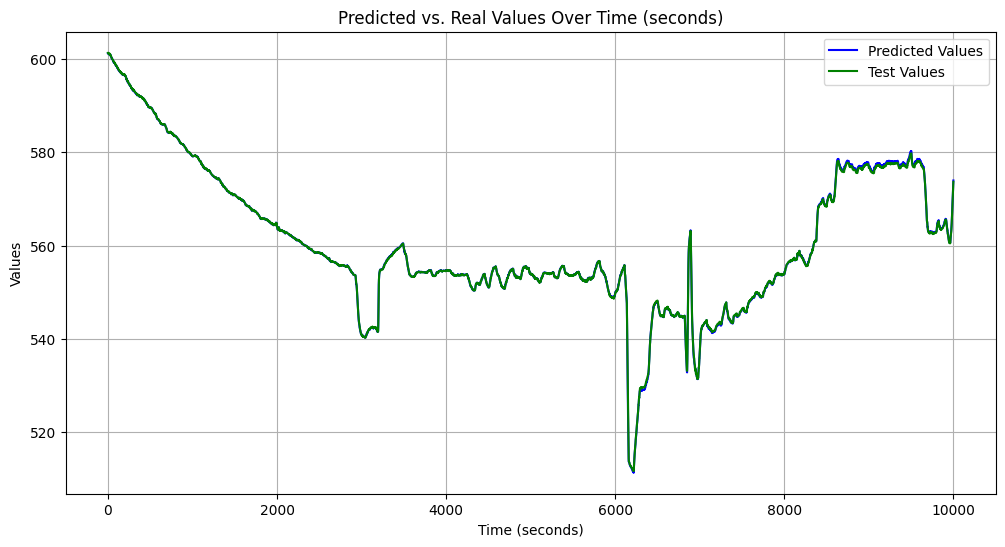

In [73]:


# Assuming y_predict contains your predicted values
# Create a time index based on the number of data points
time_seconds = np.arange(len(y_predict))  # This creates an index from 0 to len(y_predict) - 1

time_seconds = np.arange(len(y_test))  # This creates an index from 0 to len(y_predict) - 1

# Define the time range you want to plot (0 to 1000 seconds)
start_time = 0
end_time = 10000

# Find the indices corresponding to the selected time range
start_index = np.argmax(time_seconds >= start_time)
end_index = np.argmax(time_seconds >= end_time)

# Slice the y_predict and time_seconds arrays to select the desired time range
y_predict_subset = y_predict[start_index:end_index]
time_subset = time_seconds[start_index:end_index]

# Slice the y_test and time_seconds arrays to select the desired time range
y_test_subset = y_test[start_index:end_index]
time_subset = time_seconds[start_index:end_index]

# Create a figure and subplot
plt.figure(figsize=(12, 6))

# Plotting the predicted values against time
plt.plot(time_subset, y_predict_subset, label='Predicted Values', color='blue')

# Plotting the test values against time
plt.plot(time_subset, y_test_subset, label='Test Values', color='green')


# Add labels and a legend
plt.xlabel('Time (seconds)')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.title('Predicted vs. Real Values Over Time (seconds)')
plt.grid(True)
plt.show()


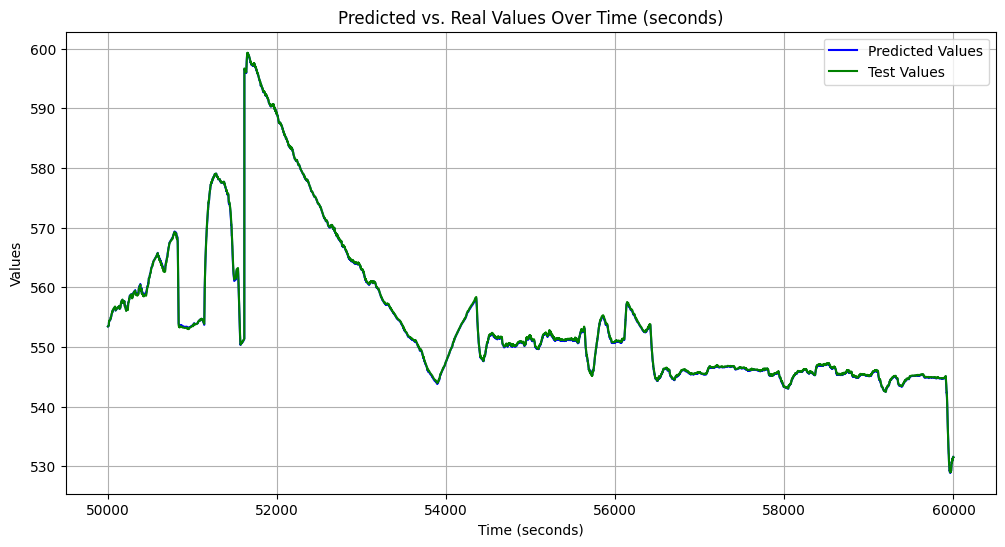

In [74]:


# Assuming y_predict contains your predicted values
# Create a time index based on the number of data points
time_seconds = np.arange(len(y_predict))  # This creates an index from 0 to len(y_predict) - 1

time_seconds = np.arange(len(y_test))  # This creates an index from 0 to len(y_predict) - 1

# Define the time range you want to plot (0 to 1000 seconds)
start_time = 50000
end_time = 60000

# Find the indices corresponding to the selected time range
start_index = np.argmax(time_seconds >= start_time)
end_index = np.argmax(time_seconds >= end_time)

# Slice the y_predict and time_seconds arrays to select the desired time range
y_predict_subset = y_predict[start_index:end_index]
time_subset = time_seconds[start_index:end_index]

# Slice the y_test and time_seconds arrays to select the desired time range
y_test_subset = y_test[start_index:end_index]
time_subset = time_seconds[start_index:end_index]

# Create a figure and subplot
plt.figure(figsize=(12, 6))

# Plotting the predicted values against time
plt.plot(time_subset, y_predict_subset, label='Predicted Values', color='blue')

# Plotting the test values against time
plt.plot(time_subset, y_test_subset, label='Test Values', color='green')


# Add labels and a legend
plt.xlabel('Time (seconds)')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.title('Predicted vs. Real Values Over Time (seconds)')
plt.grid(True)
plt.show()




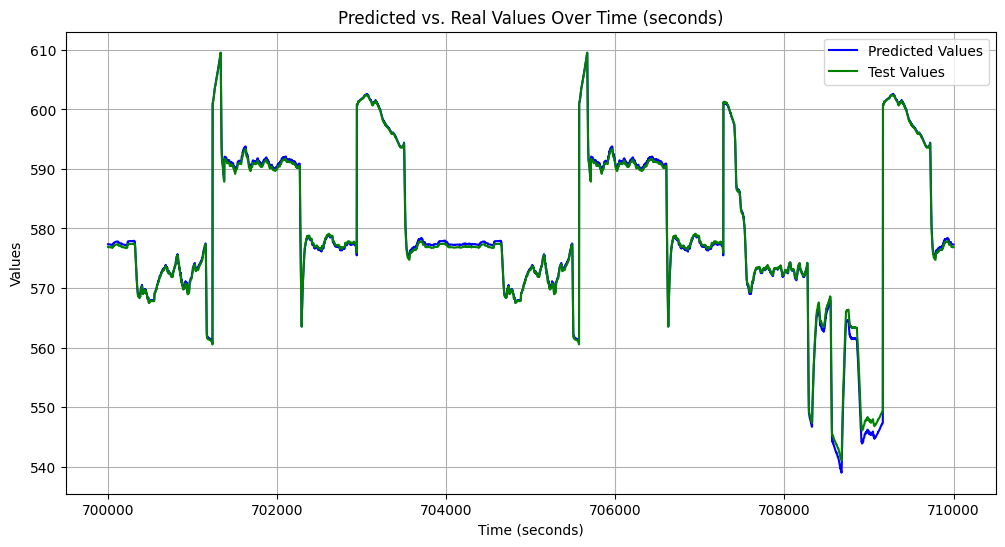

In [69]:


# Assuming y_predict contains your predicted values
# Create a time index based on the number of data points
time_seconds = np.arange(len(y_predict))  # This creates an index from 0 to len(y_predict) - 1

time_seconds = np.arange(len(y_test))  # This creates an index from 0 to len(y_predict) - 1

# Define the time range you want to plot (0 to 1000 seconds)
start_time = 700000
end_time = 710000

# Find the indices corresponding to the selected time range
start_index = np.argmax(time_seconds >= start_time)
end_index = np.argmax(time_seconds >= end_time)

# Slice the y_predict and time_seconds arrays to select the desired time range
y_predict_subset = y_predict[start_index:end_index]
time_subset = time_seconds[start_index:end_index]

# Slice the y_test and time_seconds arrays to select the desired time range
y_test_subset = y_test[start_index:end_index]
time_subset = time_seconds[start_index:end_index]

# Create a figure and subplot
plt.figure(figsize=(12, 6))

# Plotting the predicted values against time
plt.plot(time_subset, y_predict_subset, label='Predicted Values', color='blue')

# Plotting the test values against time
plt.plot(time_subset, y_test_subset, label='Test Values', color='green')


# Add labels and a legend
plt.xlabel('Time (seconds)')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.title('Predicted vs. Real Values Over Time (seconds)')
plt.grid(True)
plt.show()


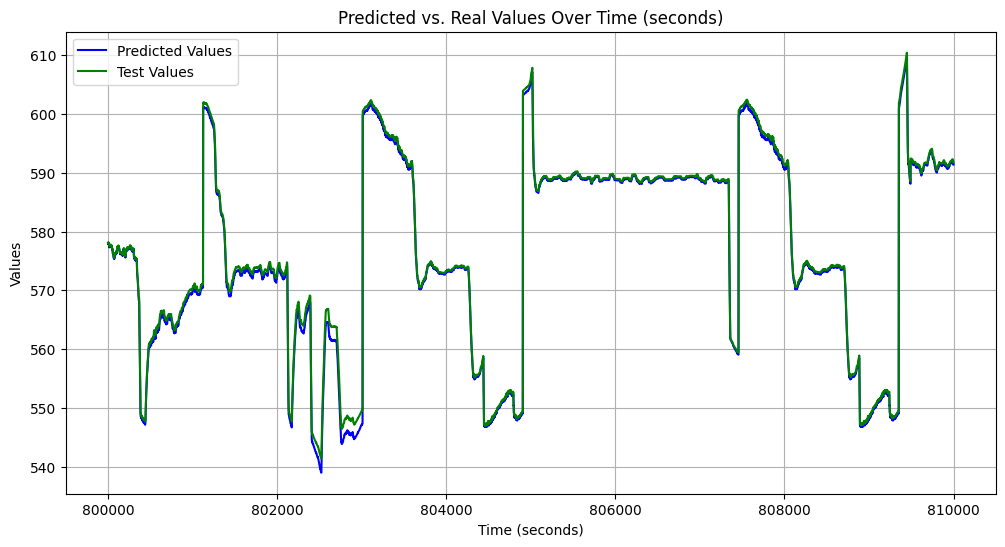

In [71]:


# Assuming y_predict contains your predicted values
# Create a time index based on the number of data points
time_seconds = np.arange(len(y_predict))  # This creates an index from 0 to len(y_predict) - 1

time_seconds = np.arange(len(y_test))  # This creates an index from 0 to len(y_predict) - 1

# Define the time range you want to plot (0 to 1000 seconds)
start_time = 800000
end_time = 810000

# Find the indices corresponding to the selected time range
start_index = np.argmax(time_seconds >= start_time)
end_index = np.argmax(time_seconds >= end_time)

# Slice the y_predict and time_seconds arrays to select the desired time range
y_predict_subset = y_predict[start_index:end_index]
time_subset = time_seconds[start_index:end_index]

# Slice the y_test and time_seconds arrays to select the desired time range
y_test_subset = y_test[start_index:end_index]
time_subset = time_seconds[start_index:end_index]

# Create a figure and subplot
plt.figure(figsize=(12, 6))

# Plotting the predicted values against time
plt.plot(time_subset, y_predict_subset, label='Predicted Values', color='blue')

# Plotting the test values against time
plt.plot(time_subset, y_test_subset, label='Test Values', color='green')


# Add labels and a legend
plt.xlabel('Time (seconds)')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.title('Predicted vs. Real Values Over Time (seconds)')
plt.grid(True)
plt.show()


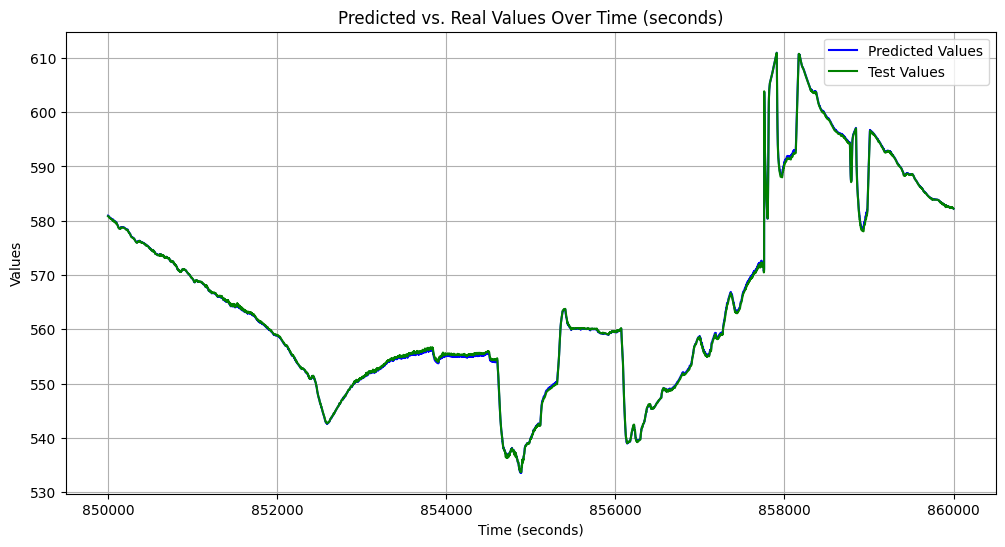

In [72]:


# Assuming y_predict contains your predicted values
# Create a time index based on the number of data points
time_seconds = np.arange(len(y_predict))  # This creates an index from 0 to len(y_predict) - 1

time_seconds = np.arange(len(y_test))  # This creates an index from 0 to len(y_predict) - 1

# Define the time range you want to plot (0 to 1000 seconds)
start_time = 850000
end_time = 860000

# Find the indices corresponding to the selected time range
start_index = np.argmax(time_seconds >= start_time)
end_index = np.argmax(time_seconds >= end_time)

# Slice the y_predict and time_seconds arrays to select the desired time range
y_predict_subset = y_predict[start_index:end_index]
time_subset = time_seconds[start_index:end_index]

# Slice the y_test and time_seconds arrays to select the desired time range
y_test_subset = y_test[start_index:end_index]
time_subset = time_seconds[start_index:end_index]

# Create a figure and subplot
plt.figure(figsize=(12, 6))

# Plotting the predicted values against time
plt.plot(time_subset, y_predict_subset, label='Predicted Values', color='blue')

# Plotting the test values against time
plt.plot(time_subset, y_test_subset, label='Test Values', color='green')


# Add labels and a legend
plt.xlabel('Time (seconds)')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.title('Predicted vs. Real Values Over Time (seconds)')
plt.grid(True)
plt.show()


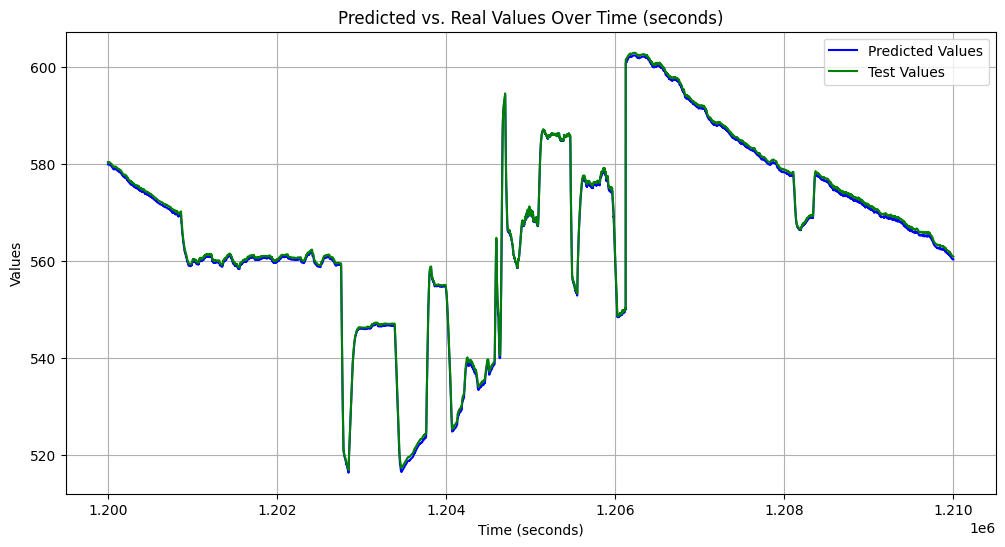

In [75]:


# Assuming y_predict contains your predicted values
# Create a time index based on the number of data points
time_seconds = np.arange(len(y_predict))  # This creates an index from 0 to len(y_predict) - 1

time_seconds = np.arange(len(y_test))  # This creates an index from 0 to len(y_predict) - 1

# Define the time range you want to plot (0 to 1000 seconds)
start_time = 1200000
end_time = 1210000

# Find the indices corresponding to the selected time range
start_index = np.argmax(time_seconds >= start_time)
end_index = np.argmax(time_seconds >= end_time)

# Slice the y_predict and time_seconds arrays to select the desired time range
y_predict_subset = y_predict[start_index:end_index]
time_subset = time_seconds[start_index:end_index]

# Slice the y_test and time_seconds arrays to select the desired time range
y_test_subset = y_test[start_index:end_index]
time_subset = time_seconds[start_index:end_index]

# Create a figure and subplot
plt.figure(figsize=(12, 6))

# Plotting the predicted values against time
plt.plot(time_subset, y_predict_subset, label='Predicted Values', color='blue')

# Plotting the test values against time
plt.plot(time_subset, y_test_subset, label='Test Values', color='green')


# Add labels and a legend
plt.xlabel('Time (seconds)')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.title('Predicted vs. Real Values Over Time (seconds)')
plt.grid(True)
plt.show()


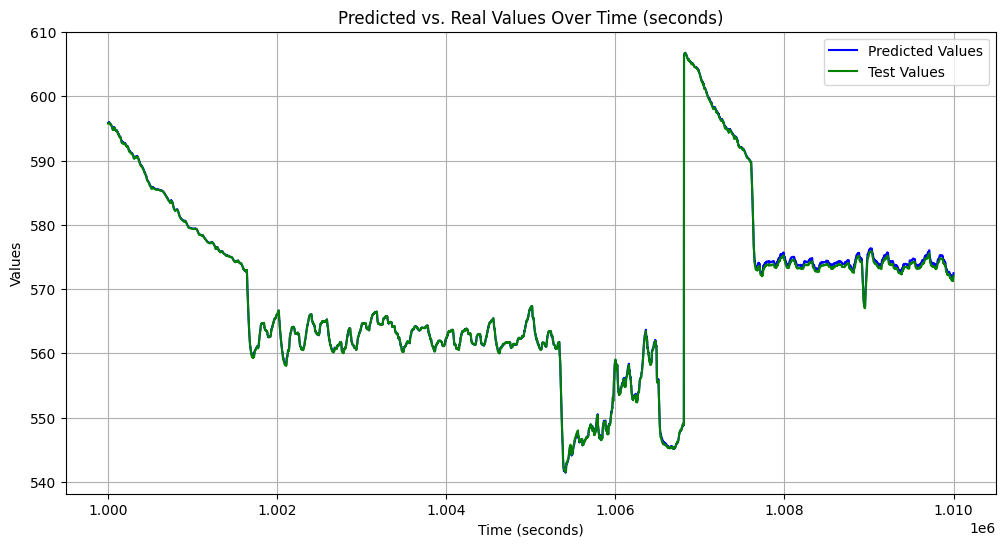

In [70]:


# Assuming y_predict contains your predicted values
# Create a time index based on the number of data points
time_seconds = np.arange(len(y_predict))  # This creates an index from 0 to len(y_predict) - 1

time_seconds = np.arange(len(y_test))  # This creates an index from 0 to len(y_predict) - 1

# Define the time range you want to plot (0 to 1000 seconds)
start_time = 1000000
end_time = 1010000

# Find the indices corresponding to the selected time range
start_index = np.argmax(time_seconds >= start_time)
end_index = np.argmax(time_seconds >= end_time)

# Slice the y_predict and time_seconds arrays to select the desired time range
y_predict_subset = y_predict[start_index:end_index]
time_subset = time_seconds[start_index:end_index]

# Slice the y_test and time_seconds arrays to select the desired time range
y_test_subset = y_test[start_index:end_index]
time_subset = time_seconds[start_index:end_index]

# Create a figure and subplot
plt.figure(figsize=(12, 6))

# Plotting the predicted values against time
plt.plot(time_subset, y_predict_subset, label='Predicted Values', color='blue')

# Plotting the test values against time
plt.plot(time_subset, y_test_subset, label='Test Values', color='green')


# Add labels and a legend
plt.xlabel('Time (seconds)')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.title('Predicted vs. Real Values Over Time (seconds)')
plt.grid(True)
plt.show()


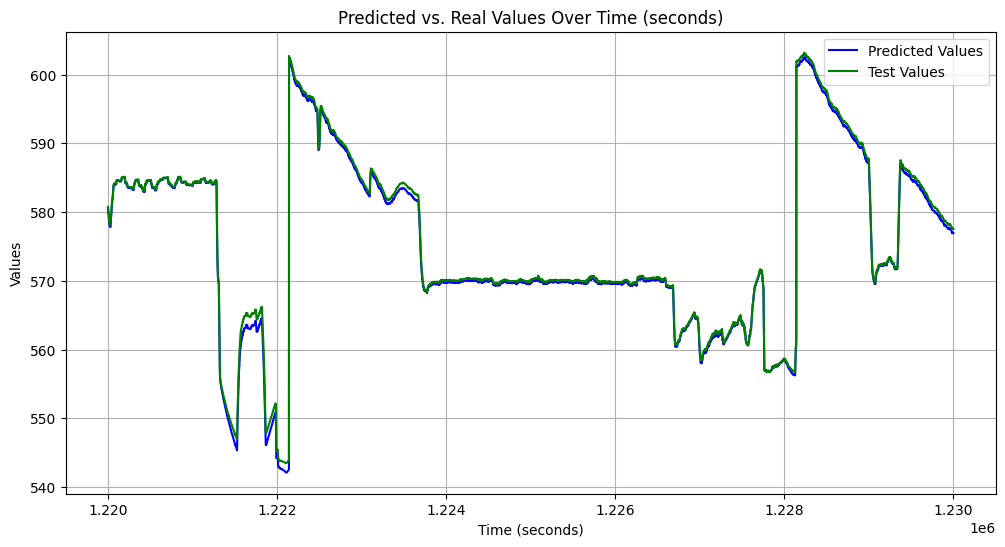

In [77]:


# Assuming y_predict contains your predicted values
# Create a time index based on the number of data points
time_seconds = np.arange(len(y_predict))  # This creates an index from 0 to len(y_predict) - 1

time_seconds = np.arange(len(y_test))  # This creates an index from 0 to len(y_predict) - 1

# Define the time range you want to plot (0 to 1000 seconds)
start_time = 1220000
end_time = 1230000

# Find the indices corresponding to the selected time range
start_index = np.argmax(time_seconds >= start_time)
end_index = np.argmax(time_seconds >= end_time)

# Slice the y_predict and time_seconds arrays to select the desired time range
y_predict_subset = y_predict[start_index:end_index]
time_subset = time_seconds[start_index:end_index]

# Slice the y_test and time_seconds arrays to select the desired time range
y_test_subset = y_test[start_index:end_index]
time_subset = time_seconds[start_index:end_index]

# Create a figure and subplot
plt.figure(figsize=(12, 6))

# Plotting the predicted values against time
plt.plot(time_subset, y_predict_subset, label='Predicted Values', color='blue')

# Plotting the test values against time
plt.plot(time_subset, y_test_subset, label='Test Values', color='green')


# Add labels and a legend
plt.xlabel('Time (seconds)')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.title('Predicted vs. Real Values Over Time (seconds)')
plt.grid(True)
plt.show()


In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming you have your model predictions and actual target values
# Replace 'predicted_values' and 'actual_values' with your actual data
predicted_values = y_predict  # Replace with your model's predictions
actual_values = y_test     # Replace with the actual target values

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predicted_values)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predicted_values)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R-squared (R2)
r2 = r2_score(actual_values, predicted_values)
print(f"R-squared (R2): {r2}")


Mean Absolute Error (MAE): 0.28178962591260365
Mean Squared Error (MSE): 0.17211725901492694
Root Mean Squared Error (RMSE): 0.41487017127642106
R-squared (R2): 0.9994760032038645


In [4]:
#pre-processing of development / train data focused only in Fight class 3 

df_A_2 = DataFrame(data=A_dev, columns=A_var)
df_W_2 = DataFrame(data=W_dev, columns=W_var)
df_T_2 = DataFrame(data=T_dev, columns=T_var)


df_W_2['Fc'] = df_A_2['Fc'].values
df_W_2_u = df_W_2.loc[df_A_2.Fc == 3]

df_W_2_u_1= df_W_2_u[['alt', 'Mach', 'TRA', 'T2']]

df_T_2['Fc'] = df_A_2['Fc'].values
df_T_2_u = df_T_2.loc[df_A_2.Fc == 3]

df_T_2_u_1= df_T_2_u [['fan_eff_mod','fan_flow_mod','LPC_eff_mod', 'LPC_flow_mod','HPC_eff_mod','HPC_flow_mod','HPT_eff_mod','HPT_flow_mod','LPT_eff_mod', 'LPT_flow_mod']]
X_train = pd.concat([df_W_2_u_1, df_T_2_u_1], axis=1)
print(X_train)


             alt      Mach        TRA          T2  fan_eff_mod  fan_flow_mod  \
0        10005.0  0.448497  76.903748  502.420918          0.0           0.0   
1        10013.0  0.447741  76.903748  502.326114          0.0           0.0   
2        10017.0  0.448938  77.079529  502.416067          0.0           0.0   
3        10024.0  0.449883  77.079529  502.469893          0.0           0.0   
4        10031.0  0.449379  77.079529  502.401271          0.0           0.0   
...          ...       ...        ...         ...          ...           ...   
5263442  10036.0  0.502866  38.407928  507.301734          0.0           0.0   
5263443  10026.0  0.502551  38.583710  507.308340          0.0           0.0   
5263444  10020.0  0.502866  38.847378  507.361541          0.0           0.0   
5263445  10012.0  0.502740  38.935268  507.380028          0.0           0.0   
5263446  10002.0  0.502740  39.111050  507.415994          0.0           0.0   

         LPC_eff_mod  LPC_flow_mod  HPC

In [5]:
from sklearn.preprocessing import StandardScaler

X_train.columns = [str(col) for col in X_train.columns]


scaler = StandardScaler()
scaler.fit(X_train)
scaler_data = scaler.transform(X_train)


In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(scaler_data)


PCA(n_components=2)

In [7]:
x_pca = pca.transform(scaler_data)
print(scaler_data.shape)
print(x_pca.shape)

(5263447, 14)
(5263447, 2)


In [8]:
df_X_s_2 = DataFrame(data=X_s_dev, columns=X_s_var)
df_X_s_2['Fc'] = df_A_2['Fc'].values
df_X_s_2_u = df_X_s_2.loc[df_A_2.Fc == 3]
y_train = df_X_s_2_u['T48']

print(y_train)


0          1818.027714
1          1817.682618
2          1820.020627
3          1819.188327
4          1818.963540
              ...     
5263442    1549.487006
5263443    1552.522723
5263444    1555.489945
5263445    1554.725363
5263446    1557.553338
Name: T48, Length: 5263447, dtype: float64


In [9]:

# Assuming x_pca is your NumPy array
fraction_to_keep = 0.05  # Adjust as needed

# Get the number of rows to keep
num_rows_to_keep = int(len(x_pca) * fraction_to_keep)

# Randomly select a subset of rows
np.random.seed(42)  # For reproducibility
random_indices = np.random.choice(len(x_pca), size=num_rows_to_keep, replace=False)
x_pca_train_subset = x_pca[random_indices]

print(x_pca_train_subset.shape)
print(x_pca_train_subset)


(263172, 2)
[[-2.1100235  -0.276086  ]
 [-1.75232046 -0.60332108]
 [-2.56091557 -0.76113767]
 ...
 [-2.37166275 -0.74077237]
 [ 2.75192476 -0.35117486]
 [-2.81362483 -0.74458075]]


In [10]:

# Assuming x_pca is your NumPy array
fraction_to_keep = 0.05  # Adjust as needed

# Get the number of rows to keep
num_rows_to_keep = int(len(y_train) * fraction_to_keep)

# Randomly select a subset of rows
np.random.seed(42)  # For reproducibility
random_indices = np.random.choice(len(y_train), size=num_rows_to_keep, replace=False)
y_train_subset = y_train[random_indices]

print(y_train_subset.shape)


(263172,)


In [11]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to your training data and transform it
X_train_scaled = scaler.fit_transform(x_pca_train_subset)

# Transform your test data using the same scaler
#X_test_scaled = scaler.transform(X_test)

In [12]:
# Create an SVR regressor with an appropriate kernel (e.g., 'rbf')
regressorOne = SVR(kernel='rbf')

# Train the regressor on the training data
regressorOne.fit(X_train_scaled, y_train_subset)

SVR()

In [13]:
regressorOne.score(X_train_scaled, y_train_subset)

0.09414691598174718

In [16]:

df_A_3 = DataFrame(data=A_test, columns=A_var)
df_X_s_3 = DataFrame(data=X_s_test, columns=X_s_var)

df_X_s_3['Fc'] = df_A_3['Fc'].values
df_X_s_3_u = df_X_s_3.loc[df_A_3.Fc == 3]
y_test = df_X_s_3_u['T48']



print(y_test.shape)

(663495,)


In [17]:
df_W_3 = DataFrame(data=W_test, columns=W_var)
df_T_3 = DataFrame(data=T_test, columns=T_var)


df_W_3['Fc'] = df_A_3['Fc'].values
df_W_3_u = df_W_3.loc[df_A_3.Fc == 3]

df_W_3_u_1= df_W_3_u[['alt', 'Mach', 'TRA', 'T2']]

df_T_3['Fc'] = df_A_3['Fc'].values
df_T_3_u = df_T_3.loc[df_A_3.Fc == 3]

df_T_3_u_1= df_T_3_u [['fan_eff_mod','fan_flow_mod','LPC_eff_mod', 'LPC_flow_mod','HPC_eff_mod','HPC_flow_mod','HPT_eff_mod','HPT_flow_mod','LPT_eff_mod', 'LPT_flow_mod']]
X_test = pd.concat([df_W_3_u_1, df_T_3_u_1], axis=1)
print(X_test)

            alt      Mach        TRA          T2  fan_eff_mod  fan_flow_mod  \
0       10014.0  0.457506  77.255310  503.176696          0.0           0.0   
1       10020.0  0.457947  77.255310  503.192949          0.0           0.0   
2       10029.0  0.458451  77.255310  503.203187          0.0           0.0   
3       10034.0  0.458136  77.255310  503.158580          0.0           0.0   
4       10045.0  0.458010  77.255310  503.105629          0.0           0.0   
...         ...       ...        ...         ...          ...           ...   
663490  10026.0  0.406224  26.630671  498.852810          0.0           0.0   
663491  10021.0  0.405468  26.630671  498.813595          0.0           0.0   
663492  10015.0  0.404838  26.630671  498.785571          0.0           0.0   
663493  10008.0  0.405153  26.630671  498.834691          0.0           0.0   
663494  10003.0  0.404082  26.630671  498.771997          0.0           0.0   

        LPC_eff_mod  LPC_flow_mod  HPC_eff_mod  HPC

In [19]:
from sklearn.preprocessing import StandardScaler

X_test.columns = [str(col) for col in X_test.columns]


scaler_1 = StandardScaler()
scaler_1.fit(X_test)
scaler_data_1 = scaler_1.transform(X_test)

from sklearn.decomposition import PCA
pca_1 = PCA(n_components=2)
pca_1.fit(scaler_data_1)

x_pca_1 = pca_1.transform(scaler_data_1)
print(scaler_data_1.shape)
print(x_pca_1.shape)

(663495, 14)
(663495, 2)


In [23]:
x_pca_1 = scaler.transform(X_test)

y_pred = regressorOne.predict(x_pca_1)


c:\Users\Diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


ValueError: X has 14 features, but MinMaxScaler is expecting 2 features as input.

In [ ]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
time_seconds = np.arange(len(y_test))  # This creates an index from 0 to len(y_predict) - 1
time_seconds = np.arange(len(y_predict))  # This creates an index from 0 to len(y_predict) - 1

# Plotting the predicted values against time
plt.plot(time_seconds, y_predict, label='Predicted Values', color='blue')

# Plotting the predicted values against time
plt.plot(time_seconds, y_test, label='Predicted Values', color='Green')

# Add labels and a legend
plt.xlabel('Time (seconds)')
plt.ylabel('Test Values')
plt.legend()

# Show the plot
plt.title('Test Values Over Time')
plt.grid(True)
plt.show()